In [1]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3

In [5]:
! pip install cif

  Running setup.py bdist_wheel for cif: started
  Running setup.py bdist_wheel for cif: finished with status 'done'
  Stored in directory: C:\Users\leomf\AppData\Local\pip\Cache\wheels\19\24\d6\b1aa5be4bce0caf9cf9f7dc556ca34b80e33cd1a40bce7e3ce
Successfully built cif


In [2]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
Eastern = countrycodes["Region (IMF)"] == "Eastern Europe"
Western = countrycodes["Region (IMF)"] == "Western Europe"
countrycodes = countrycodes[Eastern | Western]
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

ECB_countries = ["Austria", "Belgium", "Denmark", "Finland", "France", "Germany", "Greece", "Ireland","Italy", "Luxembourg", "Netherlands", "Portugal", "Spain", "Sweden", "United Kingdom"]
countrycodes = countrycodes[countrycodes["country"].isin(ECB_countries)]

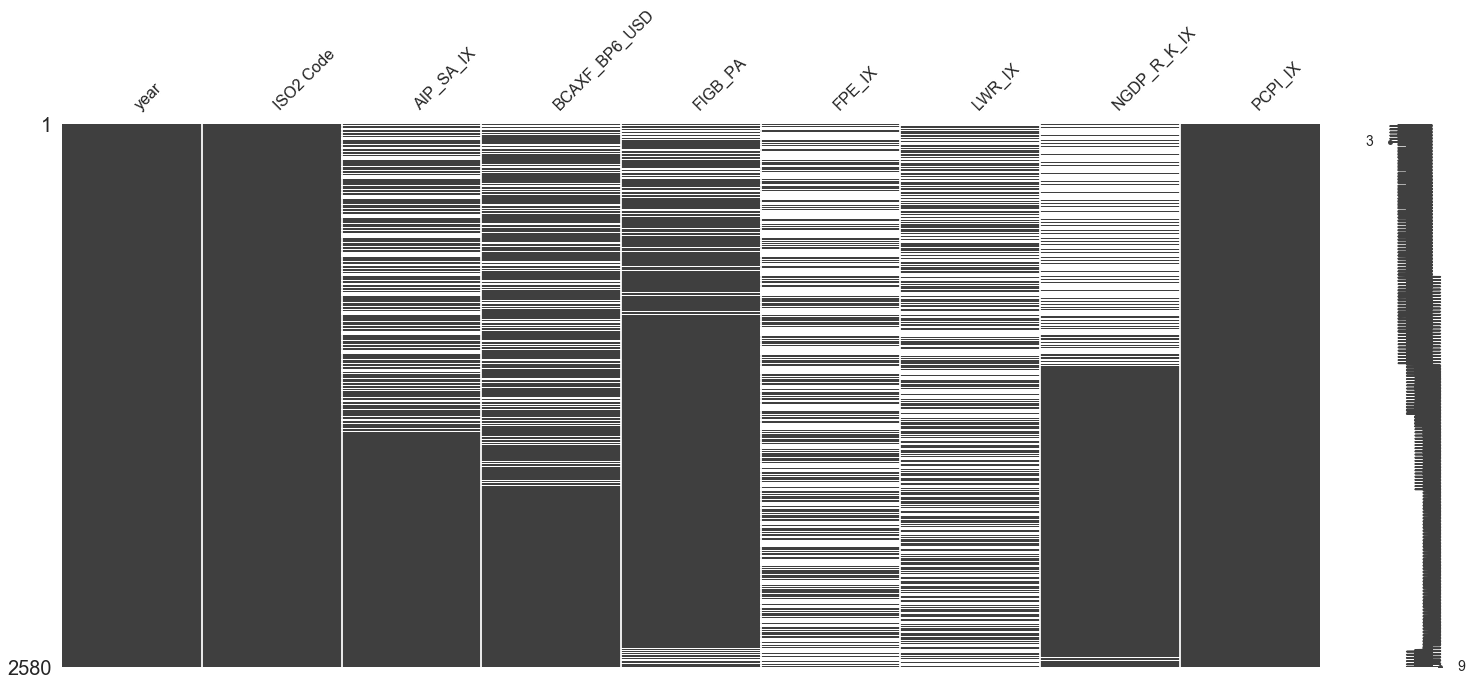

In [3]:
# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')

#Variables
variables = ".PCPI_IX+FIGB_PA+BCAXF_BP6_USD+NGDP_R_K_IX+LWR_IX+AIP_SA_IX+FPE_IX.?startPeriod=1976&endPeriod=2018"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stack)
stack = pd.merge(stack, countrycodes[["ISO2 Code", "ISO Code"]], on = "ISO2 Code")

In [6]:
from cif import cif

data_all, subjects_all, measures_all = cif.createDataFrameFromOECD(countries = countrycodes["ISO Code"].tolist(), frequency = 'Q', subject = ["SPASTT01"])


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AUT.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/AUT.SPASTT01..Q/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BEL.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/BEL.SPASTT01..Q/all?dimensionAtObservation=AllDimensions


C:\Users\leomf\Anaconda3\lib\site-packages\cif\cif.py:251: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dataAll = pd.concat([dataAll, dataPart], axis = 1)


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DNK.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/DNK.SPASTT01..Q/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/FIN.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/FIN.SPASTT01..Q/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/FRA.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/FRA.SPASTT01..Q/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DEU.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/DEU.SPASTT01..Q/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/GRC.SPASTT01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/GRC.SPASTT01..Q/all?dimensionAtObservation=AllDimensions
Requesting URL http:

In [7]:
oecd = data_all.stack(level = 0)
oecd.columns = oecd.columns.droplevel(0)
oecd = oecd.reset_index()
oecd = oecd.drop(['GP', 'GY'], axis=1)  


In [8]:
full = pd.merge(stack, oecd, left_on = ["ISO Code", "year"], right_on = ["country", "level_0"], how = "left")



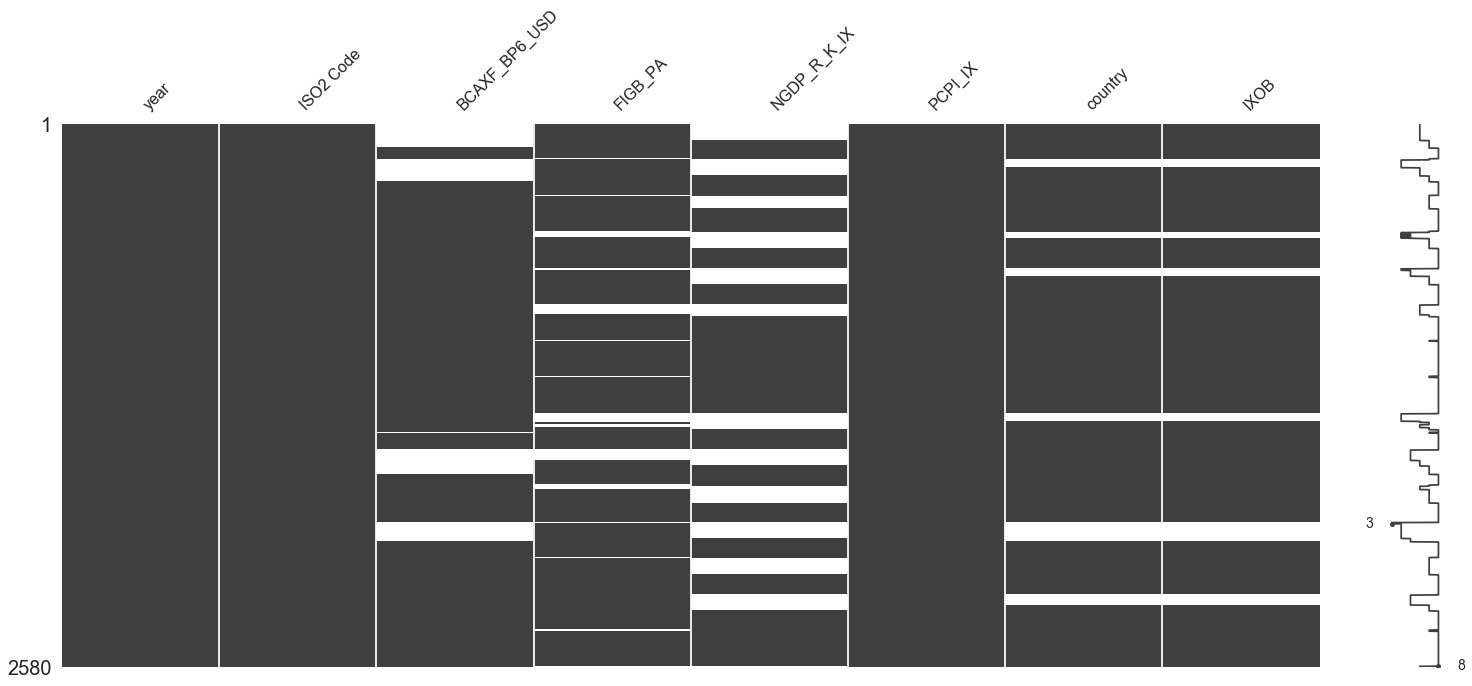

In [9]:
full = full.drop(["AIP_SA_IX", "LWR_IX", "FPE_IX", "ISO Code", "level_0"], axis = 1)
msno.matrix(full)

In [10]:
from io import BytesIO
import pandas as pd
from urllib.request import urlopen
from zipfile import ZipFile

z = urlopen('https://www.bis.org/statistics/full_bis_total_credit_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_TOTAL_CREDIT_DATAFLOW_csv_col.csv')
credit =pd.read_csv(myzip)


credit = credit[(credit["Borrowing sector"] == "Private non-financial sector") | (credit["Borrowing sector"] == "General government")]
credit = credit[(credit["Lending sector"] == "All sectors")]
credit = credit[(credit["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
credit = credit[(credit["Unit type"] == "Percentage of GDP")]
credit = credit[(credit["TC_ADJUST"] == "A")]
credit = credit[(credit["Valuation"] == "Market value")]
credit = (credit.set_index(['Borrowing sector', 'BORROWERS_CTY'])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack('Borrowing sector')
   .reset_index())
credit = credit.iloc[13:]

In [11]:
z = urlopen('https://www.bis.org/statistics/full_bis_dsr_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_DSR_DATAFLOW_csv_col.csv')
debt_service =pd.read_csv(myzip)

debt_service = debt_service[(debt_service["Borrowers"] == "Private non-financial sector")]
debt_service = debt_service[(debt_service["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
debt_service = (debt_service.set_index(['BORROWERS_CTY', "Borrowers"])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack("Borrowers")
   .reset_index())

debt_service = debt_service.iloc[5:]
debt_service.columns = debt_service.columns = ["BORROWERS_CTY", "Year", "debt_service"]

In [12]:
house_prices = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HOUSECOST.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")
house_prices = house_prices[(house_prices["FREQUENCY"] == "Q")]
house_prices = house_prices[(house_prices["LOCATION"].isin(countrycodes["ISO Code"]))]
house_prices = house_prices[(house_prices["SUBJECT"] == "PRICEINCOME")]
house_prices = house_prices.drop(columns=["INDICATOR", "SUBJECT", "MEASURE", "FREQUENCY", "Flag Codes"])
house_prices.columns = house_prices.columns = ["LOCATION", "TIME", "House_prices"]

In [13]:
full = pd.merge(full, credit, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, debt_service, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, house_prices, left_on = ["country", "year"], right_on = ["LOCATION", "TIME"], how = "left")

In [14]:
full = full.drop(columns = ["country", "Year_x", "BORROWERS_CTY_x", "BORROWERS_CTY_y", "Year_y", "LOCATION", "TIME"])
full[["BCAXF_BP6_USD", "FIGB_PA", "NGDP_R_K_IX", "PCPI_IX", "IXOB", "General government", "Private non-financial sector", "debt_service", "House_prices"]] = full[["BCAXF_BP6_USD", "FIGB_PA", "NGDP_R_K_IX", "PCPI_IX", "IXOB", "General government", "Private non-financial sector", "debt_service", "House_prices"]].apply(pd.to_numeric)


In [15]:
full["date"] = pd.to_datetime(full['year'])
full1990 = full[full["date"] > "1990-01-01"]

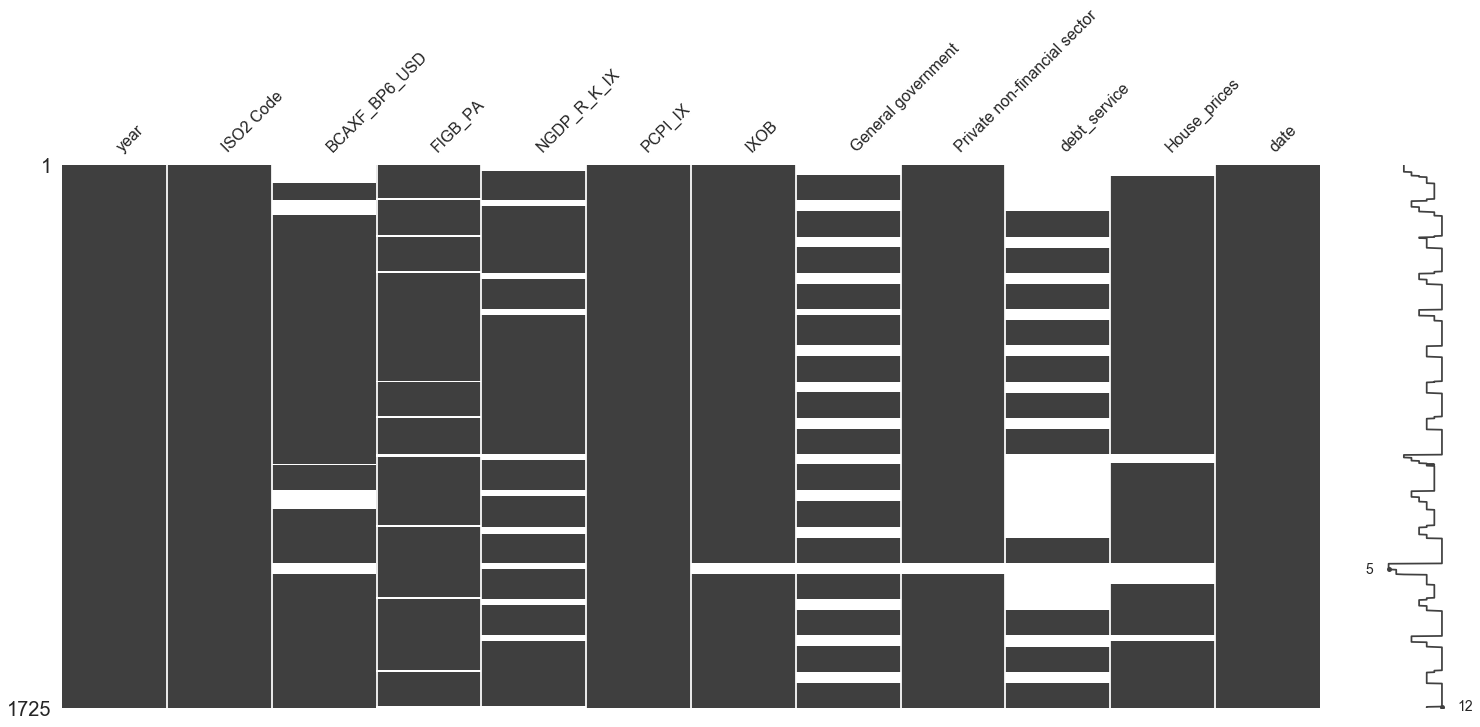

In [16]:
msno.matrix(full1990)

In [17]:
full["gdp_growth"] = full.groupby('ISO2 Code', sort=False).NGDP_R_K_IX.apply(
     lambda x: x.pct_change(4))

full.rename(columns={'Private non-financial sector':'credit_private', 'General government': 'credit_government'}, inplace=True)

full["credit_growth"] = full.groupby('ISO2 Code', sort=False).credit_private.apply(
     lambda x: x.pct_change(4))

full["inflation"] = full.groupby('ISO2 Code', sort=False).PCPI_IX.apply(
     lambda x: x.pct_change(4))

full["stock_growth"]  = full.groupby('ISO2 Code', sort=False).IXOB.apply(
     lambda x: x.pct_change(4))




In [18]:
import statsmodels.api as sm

### Creating credit gap variable

groups = full.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['credit_private']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=129600)

    g['credit_gap'] = trend
    bs = bs.append(g)

bs

,year,ISO2 Code,BCAXF_BP6_USD,FIGB_PA,NGDP_R_K_IX,PCPI_IX,IXOB,credit_government,credit_private,debt_service,House_prices,date,gdp_growth,credit_growth,inflation,stock_growth,credit_gap
0,1976-Q1,AT,NaN,9.166667,NaN,37.762549,14.891586,NaN,58.3,NaN,NaN,1976-01-01,NaN,NaN,NaN,NaN,64.237105
1,1976-Q2,AT,NaN,8.740000,NaN,38.422733,14.883415,NaN,59.6,NaN,NaN,1976-04-01,NaN,NaN,NaN,NaN,64.852531
2,1976-Q3,AT,NaN,8.546667,NaN,38.943542,14.647182,NaN,60.7,NaN,NaN,1976-07-01,NaN,NaN,NaN,NaN,65.467911
3,1976-Q4,AT,NaN,8.553333,NaN,39.332322,14.376490,NaN,64.0,NaN,NaN,1976-10-01,NaN,NaN,NaN,NaN,66.083158
4,1977-Q1,AT,NaN,8.516667,NaN,40.161218,14.279155,NaN,63.1,NaN,NaN,1977-01-01,NaN,0.082333,0.063520,-0.041126,66.698150
5,1977-Q2,AT,NaN,8.586667,NaN,40.608676,14.186083,NaN,64.7,NaN,NaN,1977-04-01,NaN,0.085570,0.056892,-0.046853,67.312748
6,1977-Q3,AT,NaN,8.840000,NaN,41.056135,13.824805,NaN,65.2,NaN,NaN,1977-07-01,NaN,0.074135,0.054248,-0.056146,67.926785
7,1977-Q4,AT,NaN,9.010000,NaN,41.122155,12.938131,NaN,66.5,NaN,NaN,1977-10-01,NaN,0.039062,0.045505,-0.100049,68.540073
8,1978-Q1,AT,NaN,8.793333,NaN,41.716322,12.898344,NaN,66.7,NaN,NaN,1978-01-01,NaN,0.057052,0.038722,-0.096701,69.152404
9,1978-Q2,AT,NaN,8.233333,NaN,42.083091,12.798167,NaN,68.3,NaN,NaN,1978-04-01,NaN,0.055641,0.036308,-0.097836,69.763554


In [177]:
### Creating house price gap variable
groups = bs.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs2 = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['House_prices']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['house_gap'] = trend
    bs2 = bs2.append(g)

bs2


,year,ISO2 Code,BCAXF_BP6_USD,FIGB_PA,NGDP_R_K_IX,PCPI_IX,IXOB,credit_government,credit_private,debt_service,House_prices,date,gdp_growth,credit_growth,inflation,stock_growth,credit_gap,house_gap
0,1976-Q1,AT,NaN,9.166667,NaN,37.762549,14.891586,NaN,58.3,NaN,NaN,1976-01-01,NaN,NaN,NaN,NaN,64.237105,NaN
1,1976-Q2,AT,NaN,8.740000,NaN,38.422733,14.883415,NaN,59.6,NaN,NaN,1976-04-01,NaN,NaN,NaN,NaN,64.852531,NaN
2,1976-Q3,AT,NaN,8.546667,NaN,38.943542,14.647182,NaN,60.7,NaN,NaN,1976-07-01,NaN,NaN,NaN,NaN,65.467911,NaN
3,1976-Q4,AT,NaN,8.553333,NaN,39.332322,14.376490,NaN,64.0,NaN,NaN,1976-10-01,NaN,NaN,NaN,NaN,66.083158,NaN
4,1977-Q1,AT,NaN,8.516667,NaN,40.161218,14.279155,NaN,63.1,NaN,NaN,1977-01-01,NaN,0.082333,0.063520,-0.041126,66.698150,NaN
5,1977-Q2,AT,NaN,8.586667,NaN,40.608676,14.186083,NaN,64.7,NaN,NaN,1977-04-01,NaN,0.085570,0.056892,-0.046853,67.312748,NaN
6,1977-Q3,AT,NaN,8.840000,NaN,41.056135,13.824805,NaN,65.2,NaN,NaN,1977-07-01,NaN,0.074135,0.054248,-0.056146,67.926785,NaN
7,1977-Q4,AT,NaN,9.010000,NaN,41.122155,12.938131,NaN,66.5,NaN,NaN,1977-10-01,NaN,0.039062,0.045505,-0.100049,68.540073,NaN
8,1978-Q1,AT,NaN,8.793333,NaN,41.716322,12.898344,NaN,66.7,NaN,NaN,1978-01-01,NaN,0.057052,0.038722,-0.096701,69.152404,NaN
9,1978-Q2,AT,NaN,8.233333,NaN,42.083091,12.798167,NaN,68.3,NaN,NaN,1978-04-01,NaN,0.055641,0.036308,-0.097836,69.763554,NaN


In [178]:
### fetching crisis database from ecb paper
ecb = pd.read_csv('data/ecbdata.csv', error_bad_lines = False, delimiter = ';')
                  

In [179]:
ecb.head()

,Country,Event,Start date,End of crisis management date,"System back ""normal"" date",Systemic crisis,Accelerator and motivation,Brief desrciption of the identified event,Crisis management policies,External support,...,Significant asset price correction,Transition,Macropru relevant,Macropru relevance explanation,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,AT,1.0,2007-12,2016-04,ongoing,1.0,"Excessive credit growth and leverage, mismatch...",The crisis evolved similarly as in many other ...,"In response to the crisis, the authorities too...",1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
1,BE,1.0,2007-11,2012-12,ongoing,1.0,"Excessive credit growth and leverage, mismatch...",The Belgian financial sector was impacted stro...,The state support measures included recapitali...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
2,BG,1.0,1996-05,1997-07,1997-07,1.0,n.a.,This crisis resulted from some features of the...,The 1996-97 crisis was resolved by introductio...,1.0,...,0.0,1.0,0.0,"This crisis is a transitional one, thus there ...",NaN,NaN,NaN,NaN,NaN,NaN
3,CY,1.0,2000-01,2001-03,2001-03,1.0,n.a.,"In early 1999 a number of events, such as the ...",None.,0.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
4,CY,2.0,2011-06,2016-03,ongoing,1.0,"Excessive credit growth and leverage, exposure...",The crisis came to a head following a build-up...,The successive downgrades in the credit rating...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
ecb = ecb[ecb['Country'].isin(full['ISO2 Code'])]

In [181]:
### Crisis database taken from the ecb paper
ecb


,Country,Event,Start date,End of crisis management date,"System back ""normal"" date",Systemic crisis,Accelerator and motivation,Brief desrciption of the identified event,Crisis management policies,External support,...,Significant asset price correction,Transition,Macropru relevant,Macropru relevance explanation,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,AT,1.0,2007-12,2016-04,ongoing,1.0,"Excessive credit growth and leverage, mismatch...",The crisis evolved similarly as in many other ...,"In response to the crisis, the authorities too...",1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
1,BE,1.0,2007-11,2012-12,ongoing,1.0,"Excessive credit growth and leverage, mismatch...",The Belgian financial sector was impacted stro...,The state support measures included recapitali...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
6,DE,1.0,1974-06,1974-11,1975-08,1.0,Exposure concentration. \n\nMotivation: \n1) A...,In the early 1970s the regime of floating exch...,To calm the situation after the Herstatt closu...,0.0,...,0.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
7,DE,2.0,2001-01,2003-11,2004-12,1.0,"Exposure concentration, excessive credit growt...","The cyclical downturn, following a domestic cr...",Most banks in distress could be stabilized or ...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
8,DE,3.0,2007-08,2013-06,ongoing,1.0,"Mismatches and market illiquidity, exposure co...",In the years before the crisis financial insti...,Initially the crisis was treated as a liquidit...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
9,DK,1.0,1987-03,1995-01,1995-01,1.0,Excessive credit growth and leverage. \n\nMoti...,In Denmark the years 1987-93 constituted an un...,The government and Danmarks Nationalbank were ...,0.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
10,DK,2.0,2008-01,2013-12,2013-12,1.0,Excessive credit growth and leverage. \n\nMoti...,An international liquidity crisis spread from ...,The government provided a safety net for the b...,0.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
14,ES,1.0,1978-01,1985-09,1985-09,1.0,Exposure concentration. \n\nMotivation: The ba...,The banking status quo was broken up in the wa...,The Spanish Bank Deposit Guarantee Fund was cr...,0.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
15,ES,2.0,2009-03,2013-12,ongoing,1.0,"Excessive credit growth and leverage, exposure...","In Spain, the crisis had several phases which ...",The lack of sufficient capital and loss-absorp...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
16,FI,1.0,1991-09,1996-12,1998-12,1.0,"Excessive credit growth and leverage, mismatch...","In 1991, Finnish economic problems intensified...",Many different policies/interventions. A detai...,0.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
ecb.rename(columns={'Start date':'start'}, inplace=True)
ecb.head()

,Country,Event,start,End of crisis management date,"System back ""normal"" date",Systemic crisis,Accelerator and motivation,Brief desrciption of the identified event,Crisis management policies,External support,...,Significant asset price correction,Transition,Macropru relevant,Macropru relevance explanation,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,AT,1.0,2007-12,2016-04,ongoing,1.0,"Excessive credit growth and leverage, mismatch...",The crisis evolved similarly as in many other ...,"In response to the crisis, the authorities too...",1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
1,BE,1.0,2007-11,2012-12,ongoing,1.0,"Excessive credit growth and leverage, mismatch...",The Belgian financial sector was impacted stro...,The state support measures included recapitali...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
6,DE,1.0,1974-06,1974-11,1975-08,1.0,Exposure concentration. \n\nMotivation: \n1) A...,In the early 1970s the regime of floating exch...,To calm the situation after the Herstatt closu...,0.0,...,0.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
7,DE,2.0,2001-01,2003-11,2004-12,1.0,"Exposure concentration, excessive credit growt...","The cyclical downturn, following a domestic cr...",Most banks in distress could be stabilized or ...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN
8,DE,3.0,2007-08,2013-06,ongoing,1.0,"Mismatches and market illiquidity, exposure co...",In the years before the crisis financial insti...,Initially the crisis was treated as a liquidit...,1.0,...,1.0,0.0,1.0,n.a.,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
### turning to quarters

ecb['Qtr'] = pd.PeriodIndex(pd.to_datetime(ecb.start), freq = 'Q')

In [184]:
crisis = ecb[['Country', 'Qtr']]

In [185]:
bs2["year"] = bs2["year"].str.replace("-", "")


In [186]:
crisis

,Country,Qtr
0,AT,2007Q4
1,BE,2007Q4
6,DE,1974Q2
7,DE,2001Q1
8,DE,2007Q3
9,DK,1987Q1
10,DK,2008Q1
14,ES,1978Q1
15,ES,2009Q1
16,FI,1991Q3


In [187]:
### Creating crises variable
crisis["dummy"] = 1
crise = pd.merge(bs2, crisis, left_on = ['ISO2 Code', 'year'], right_on = ['Country', 'year'], how = 'left')

C:\Users\leomf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: 'year'

In [188]:
crise[crise["dummy"] == 1]

,year,ISO2 Code,BCAXF_BP6_USD,FIGB_PA,NGDP_R_K_IX,PCPI_IX,IXOB,credit_government,credit_private,debt_service,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,one_year,two_year
127,2007Q4,AT,5167.184067,4.320000,104.796900,95.912306,179.512880,66.2,141.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,2007Q4,BE,-2810.299156,4.370000,103.844595,94.875475,102.550693,89.9,169.5,17.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
444,2001Q1,DE,-3796.262650,4.750000,91.917816,86.740561,74.758656,59.0,130.2,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,2007Q3,DE,52175.286526,4.340000,101.476920,96.308029,89.050544,64.6,118.4,11.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560,1987Q1,DK,-507.350296,11.433333,NaN,57.751037,7.562218,NaN,142.9,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
644,2008Q1,DK,-184.804102,4.090000,101.501094,95.420052,54.587458,28.4,231.8,30.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,1978Q1,ES,-314.582712,12.510000,NaN,14.966469,NaN,NaN,78.4,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
820,2009Q1,ES,-23701.874381,4.146667,96.625638,97.300965,79.612721,44.8,211.4,23.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
922,1991Q3,FI,-1052.400997,11.073333,63.040086,74.704377,11.320996,NaN,138.8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,1991Q2,FR,-966.139750,8.960000,72.649573,73.233736,31.331359,NaN,129.9,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
crise['dummy'].fillna(0, inplace = True)

In [190]:
### Merged database with quarter of crisis information
crise

,year,ISO2 Code,BCAXF_BP6_USD,FIGB_PA,NGDP_R_K_IX,PCPI_IX,IXOB,credit_government,credit_private,debt_service,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,one_year,two_year
0,1976Q1,AT,NaN,9.166667,NaN,37.762549,14.891586,NaN,58.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1976Q2,AT,NaN,8.740000,NaN,38.422733,14.883415,NaN,59.6,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1976Q3,AT,NaN,8.546667,NaN,38.943542,14.647182,NaN,60.7,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1976Q4,AT,NaN,8.553333,NaN,39.332322,14.376490,NaN,64.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1977Q1,AT,NaN,8.516667,NaN,40.161218,14.279155,NaN,63.1,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN
5,1977Q2,AT,NaN,8.586667,NaN,40.608676,14.186083,NaN,64.7,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
6,1977Q3,AT,NaN,8.840000,NaN,41.056135,13.824805,NaN,65.2,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN
7,1977Q4,AT,NaN,9.010000,NaN,41.122155,12.938131,NaN,66.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
8,1978Q1,AT,NaN,8.793333,NaN,41.716322,12.898344,NaN,66.7,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1978Q2,AT,NaN,8.233333,NaN,42.083091,12.798167,NaN,68.3,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(40)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(8)

In [238]:
crise["one_year"] = crise["lag_1"] + crise["lag_2"] + crise["lag_3"] +crise["lag_4"]
crise["two_year"] = crise["one_year"] +crise["lag_5"] + crise["lag_6"] + crise["lag_7"] +crise["lag_8"]

In [239]:
crise.columns

Index(['year', 'ISO2 Code', 'BCAXF_BP6_USD', 'FIGB_PA', 'NGDP_R_K_IX',
       'PCPI_IX', 'IXOB', 'credit_government', 'credit_private',
       'debt_service', 'House_prices', 'date', 'gdp_growth', 'credit_growth',
       'inflation', 'stock_growth', 'credit_gap', 'house_gap', 'Country',
       'Qtr', 'dummy', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'one_year', 'two_year'],
      dtype='object')

In [240]:
crise.isna().sum()

year                    0
ISO2 Code               0
BCAXF_BP6_USD         432
FIGB_PA               254
NGDP_R_K_IX           890
PCPI_IX                 0
IXOB                  277
credit_government    1350
credit_private         92
debt_service         1700
House_prices          569
date                    0
gdp_growth            944
credit_growth         152
inflation              60
stock_growth          337
credit_gap            172
house_gap            2064
Country              2559
Qtr                  2559
dummy                   0
lag_1                 600
lag_2                 615
lag_3                 630
lag_4                 645
lag_5                  75
lag_6                  90
lag_7                 105
lag_8                 120
one_year              645
two_year              645
dtype: int64

In [241]:
### Preparing machine learning pipeline 

from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [242]:
X =  crise[['BCAXF_BP6_USD', 'FIGB_PA', 'credit_government', 'credit_private', 'debt_service', 'House_prices', 'gdp_growth', 'credit_growth', 'inflation', 'stock_growth', 'credit_gap', 'house_gap']]
Y = crise['one_year']


In [243]:
### filling nas in database.

X.fillna(X.mean(), inplace = True)
Y.fillna(0, inplace = True)

In [244]:
### train test split

X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=crise['one_year'])

In [245]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels

In [246]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state= 1990)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [247]:
from plotly import graph_objs as go
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [248]:
from plotly import graph_objs as go

In [249]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.695825 (0.127611)
LDA: 0.709093 (0.124186)
KNN: 0.512724 (0.052454)
CART: 0.710349 (0.100857)
NB: 0.668898 (0.122701)
SVM: 0.598774 (0.063149)
AB: 0.863115 (0.083902)
GBM: 0.875438 (0.091754)
RF: 0.836672 (0.106103)
ET: 0.965357 (0.041728)


In [251]:
models

[('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False)),
 ('LDA',
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=False, tol=0.0001)),
 ('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform')),
 ('CART',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 ('NB'

In [228]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [229]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

,Model,Score
0,LR,0.9664
1,LDA,0.9602
2,KNN,0.9664
3,CART,0.9602
4,NB,0.9442
5,SVM,0.9675
6,AB,0.9659
7,GBM,0.9700
8,RF,0.9700
9,ET,0.9706


In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines 


In [257]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)
scaledScoreStandard = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

standardLR: 0.720091 (0.125753)
standardLDA: 0.709093 (0.124186)
standardKNN: 0.936565 (0.066517)
standardCART: 0.710872 (0.120077)
standardNB: 0.725305 (0.097870)
standardSVM: 0.941205 (0.052002)
standardAB: 0.871565 (0.077233)
standardGBM: 0.877295 (0.089585)
standardRF: 0.876343 (0.074286)
standardET: 0.958823 (0.047918)


,Model,Score,Model,Score
0,LR,0.9664,standardLR,0.7201
1,LDA,0.9602,standardLDA,0.7091
2,KNN,0.9664,standardKNN,0.9366
3,CART,0.9602,standardCART,0.7109
4,NB,0.9442,standardNB,0.7253
5,SVM,0.9675,standardSVM,0.9412
6,AB,0.9659,standardAB,0.8716
7,GBM,0.9700,standardGBM,0.8773
8,RF,0.9700,standardRF,0.8763
9,ET,0.9706,standardET,0.9588


In [258]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax], axis=1)
compareModels

minmaxLR: 0.713709 (0.136934)
minmaxLDA: 0.709093 (0.124186)
minmaxKNN: 0.950289 (0.058114)
minmaxCART: 0.700608 (0.115125)
minmaxNB: 0.725305 (0.097870)
minmaxSVM: 0.642263 (0.091241)
minmaxAB: 0.871565 (0.077233)
minmaxGBM: 0.875093 (0.091158)
minmaxRF: 0.861666 (0.078006)
minmaxET: 0.965756 (0.053500)


,Model,Score,Model,Score,Model,Score
0,LR,0.9664,standardLR,0.7201,minmaxLR,0.7137
1,LDA,0.9602,standardLDA,0.7091,minmaxLDA,0.7091
2,KNN,0.9664,standardKNN,0.9366,minmaxKNN,0.9503
3,CART,0.9602,standardCART,0.7109,minmaxCART,0.7006
4,NB,0.9442,standardNB,0.7253,minmaxNB,0.7253
5,SVM,0.9675,standardSVM,0.9412,minmaxSVM,0.6423
6,AB,0.9659,standardAB,0.8716,minmaxAB,0.8716
7,GBM,0.9700,standardGBM,0.8773,minmaxGBM,0.8751
8,RF,0.9700,standardRF,0.8763,minmaxRF,0.8617
9,ET,0.9706,standardET,0.9588,minmaxET,0.9658


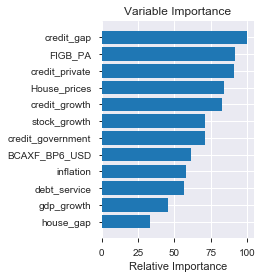

In [259]:
### feature importance

clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=1990)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [264]:
model = clf.fit(X_train, y_train)

In [269]:
### Model interpretability via shapley values

import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)


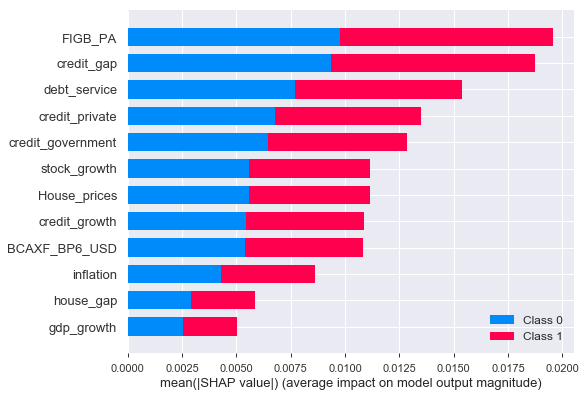

In [271]:
shap.summary_plot(shap_values, X_train)

AttributeError: 'list' object has no attribute 'shape'

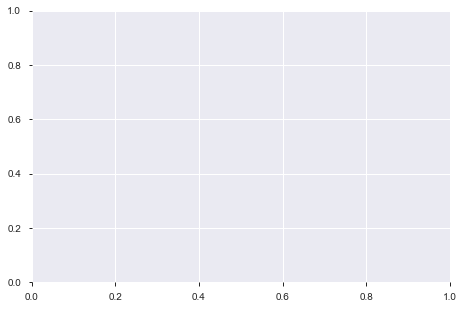

In [273]:
# setting show=False allows us to continue customizing the matplotlib plot before displaying it
shap.dependence_plot("inflation", shap_values, X_train, show=False)
pl.xlim(80,225)
pl.show()